**entorno virtual**:
hf_env\Scripts\activate

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer
from sklearn.model_selection import ParameterGrid
import numpy as np
from datasets import Dataset
from transformers import TrainingArguments
from torch.utils.data import Subset

In [8]:
# Download latest version
#https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset

In [9]:
fake = pd.read_csv(r'C:\Users\REPO\Tec2025\ModelingAI\Reto\data sets\Fake.csv')
true = pd.read_csv(r'C:\Users\REPO\Tec2025\ModelingAI\Reto\data sets\True.csv')

In [10]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [11]:
fake.describe()

,title,text,subject,date
count,23481,23481,23481,23481
unique,17903,17455,6,1681
top,MEDIA IGNORES Time That Bill Clinton FIRED His...,,News,"May 10, 2017"
freq,6,626,9050,46


In [12]:
true.describe()

,title,text,subject,date
count,21417,21417,21417,21417
unique,20826,21192,2,716
top,Factbox: Trump fills top jobs for his administ...,(Reuters) - Highlights for U.S. President Dona...,politicsNews,"December 20, 2017"
freq,14,8,11272,182


In [13]:
fake['Type'] = 0
true['Type'] = 1

In [14]:
df = pd.concat([fake, true], ignore_index=True)

In [15]:
df.nunique()

title      38729
text       38646
subject        8
date        2397
Type           2
dtype: int64

# Transformer Models

In [16]:
# Load model directly
#https://huggingface.co/therealcyberlord/fake-news-classification-distilbert

tokenizer = AutoTokenizer.from_pretrained("therealcyberlord/fake-news-classification-distilbert")
model = AutoModelForSequenceClassification.from_pretrained("therealcyberlord/fake-news-classification-distilbert")

Separar en Train y Test

In [17]:
# Paso 1: Separar texto y etiquetas
texts = df["text"].tolist()
labels = df["Type"].tolist()  # Asegúrate que estén codificadas como 0, 1, 2...

In [18]:
# Paso 2: Split
texts_train, texts_test, labels_train, labels_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

In [19]:
# Paso 3: Tokenizar cada parte
train_encodings = tokenizer(texts_train, truncation=True, padding="max_length", max_length=512, return_tensors="pt")
test_encodings = tokenizer(texts_test, truncation=True, padding="max_length", max_length=512, return_tensors="pt")

In [20]:
# Paso 4: Convertir etiquetas a tensores
train_labels = torch.tensor(labels_train)
test_labels = torch.tensor(labels_test)

Hyperparameter Tuning

In [21]:
from torch.utils.data import Dataset

class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": self.labels[idx]
        }
    
    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_encodings, train_labels)
test_dataset = NewsDataset(test_encodings, test_labels)


In [27]:
# Paso 5: Modelo base para tuning
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        "therealcyberlord/fake-news-classification-distilbert",
        num_labels=2
    )

# Paso 6: Argumentos base
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    num_train_epochs=2,  # ¡menos epochs!
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    save_strategy="no",  # no guardar checkpoints
    disable_tqdm=True,   # desactiva barra de progreso para más velocidad
    logging_steps=5,
)

In [29]:
 # Paso 7: Entrenador
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)

C:\Users\Maria Paula\AppData\Local\Temp\ipykernel_21132\1273127256.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Paso 8: Hyperparameter Tuning
# Solo una fracción para tuning

# ⚠️ Primero define los argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    num_train_epochs=1, 
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    save_strategy="no",
    logging_strategy="no",
    report_to="none",
    disable_tqdm=True
)

# Usa solo una fracción del dataset para tuning
small_train_dataset = Subset(train_dataset, range(100))
small_eval_dataset = Subset(test_dataset, range(25))

# Entrenador reducido
trainer_small = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    tokenizer=tokenizer,
)


C:\Users\Maria Paula\AppData\Local\Temp\ipykernel_21132\1490677563.py:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_small = Trainer(


In [42]:
# Búsqueda de hiperparámetros con Optuna
best_run = trainer_small.hyperparameter_search(
    direction="maximize",
    n_trials=5,
    hp_space=lambda trial: {
        "learning_rate": trial.suggest_float("learning_rate", 5e-5, 5e-4, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 12]),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 1, 2),
    }
)

print("Best run:", best_run)


[I 2025-06-15 21:28:07,670] A new study created in memory with name: no-name-e79e3c38-a960-4988-a681-046c49b5755b


{'eval_loss': 0.00010838471644092351, 'eval_runtime': 15.2352, 'eval_samples_per_second': 1.641, 'eval_steps_per_second': 0.263, 'epoch': 1.0}
{'eval_loss': 4.133018956054002e-05, 'eval_runtime': 8.0488, 'eval_samples_per_second': 3.106, 'eval_steps_per_second': 0.497, 'epoch': 2.0}
{'train_runtime': 380.2473, 'train_samples_per_second': 0.526, 'train_steps_per_second': 0.068, 'train_loss': 0.08520175860478328, 'epoch': 2.0}


[I 2025-06-15 21:34:29,069] Trial 0 finished with value: 4.133018956054002e-05 and parameters: {'learning_rate': 0.0001920050530625184, 'per_device_train_batch_size': 8, 'num_train_epochs': 2}. Best is trial 0 with value: 4.133018956054002e-05.


{'eval_loss': 0.00010841807670658454, 'eval_runtime': 8.4576, 'eval_samples_per_second': 2.956, 'eval_steps_per_second': 0.473, 'epoch': 1.0}
{'eval_loss': 4.13492634834256e-05, 'eval_runtime': 12.8736, 'eval_samples_per_second': 1.942, 'eval_steps_per_second': 0.311, 'epoch': 2.0}
{'train_runtime': 392.0536, 'train_samples_per_second': 0.51, 'train_steps_per_second': 0.066, 'train_loss': 0.08528337111839882, 'epoch': 2.0}


[I 2025-06-15 21:42:23,640] Trial 1 finished with value: 4.13492634834256e-05 and parameters: {'learning_rate': 0.00019189545486618118, 'per_device_train_batch_size': 8, 'num_train_epochs': 2}. Best is trial 1 with value: 4.13492634834256e-05.


{'eval_loss': 0.16466876864433289, 'eval_runtime': 8.2228, 'eval_samples_per_second': 3.04, 'eval_steps_per_second': 0.486, 'epoch': 1.0}
{'eval_loss': 0.003275063820183277, 'eval_runtime': 9.4227, 'eval_samples_per_second': 2.653, 'eval_steps_per_second': 0.425, 'epoch': 2.0}
{'train_runtime': 369.1585, 'train_samples_per_second': 0.542, 'train_steps_per_second': 0.049, 'train_loss': 0.424124797185262, 'epoch': 2.0}


[I 2025-06-15 21:49:54,747] Trial 2 finished with value: 0.003275063820183277 and parameters: {'learning_rate': 0.00041816745324925307, 'per_device_train_batch_size': 12, 'num_train_epochs': 2}. Best is trial 2 with value: 0.003275063820183277.


{'eval_loss': 0.00020294850401114672, 'eval_runtime': 8.6753, 'eval_samples_per_second': 2.882, 'eval_steps_per_second': 0.461, 'epoch': 1.0}
{'eval_loss': 5.876116847502999e-05, 'eval_runtime': 11.1212, 'eval_samples_per_second': 2.248, 'eval_steps_per_second': 0.36, 'epoch': 2.0}
{'train_runtime': 367.531, 'train_samples_per_second': 0.544, 'train_steps_per_second': 0.071, 'train_loss': 0.05953762622979971, 'epoch': 2.0}


[I 2025-06-15 21:57:23,999] Trial 3 finished with value: 5.876116847502999e-05 and parameters: {'learning_rate': 0.00010454424080998872, 'per_device_train_batch_size': 8, 'num_train_epochs': 2}. Best is trial 2 with value: 0.003275063820183277.


{'eval_loss': 4.643296779249795e-05, 'eval_runtime': 8.0217, 'eval_samples_per_second': 3.117, 'eval_steps_per_second': 0.499, 'epoch': 1.0}
{'train_runtime': 154.2585, 'train_samples_per_second': 0.648, 'train_steps_per_second': 0.084, 'train_loss': 0.2675761259519137, 'epoch': 1.0}


[I 2025-06-15 22:01:19,788] Trial 4 finished with value: 4.643296779249795e-05 and parameters: {'learning_rate': 0.0003200084656278733, 'per_device_train_batch_size': 8, 'num_train_epochs': 1}. Best is trial 2 with value: 0.003275063820183277.


Best run: BestRun(run_id='2', objective=0.003275063820183277, hyperparameters={'learning_rate': 0.00041816745324925307, 'per_device_train_batch_size': 12, 'num_train_epochs': 2}, run_summary=None)


# Obtener metricas con los mejores parametros

In [46]:
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Paso 1: Redefinir compute_metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [ ]:
# Paso 2: Configurar nuevos argumentos con mejores hiperparámetros
best_training_args = TrainingArguments(
    output_dir="./best_model",
    eval_strategy="epoch",
    learning_rate=0.00041816745324925307,
    per_device_train_batch_size=12,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    disable_tqdm=False
)

In [52]:
# Paso 3: Definir el trainer con los mejores hiperparámetros
best_trainer = Trainer(
    model=model_init(),
    args=best_training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics
)

In [53]:
# Paso 4: Entrenar el modelo
best_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.167685,1.000000,1.000000,1.000000,1.000000
2,0.729100,0.007913,1.000000,1.000000,1.000000,1.000000


c:\Users\Maria Paula\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\Maria Paula\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=18, training_loss=0.430086816350619, metrics={'train_runtime': 330.0523, 'train_samples_per_second': 0.606, 'train_steps_per_second': 0.055, 'total_flos': 26493479731200.0, 'train_loss': 0.430086816350619, 'epoch': 2.0})

In [54]:
# Paso 5: Evaluar y mostrar métricas
eval_results = best_trainer.evaluate()
print("Evaluación del modelo con mejores hiperparámetros:")
print(eval_results)

c:\Users\Maria Paula\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Evaluación del modelo con mejores hiperparámetros:
{'eval_loss': 0.007913410663604736, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 6.8139, 'eval_samples_per_second': 3.669, 'eval_steps_per_second': 0.587, 'epoch': 2.0}


In [60]:
small_test_dataset = Subset(test_dataset, range(100))

In [61]:
# Paso 6: Obtener predicciones para matriz de confusión
predictions = best_trainer.predict(small_test_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=-1)

c:\Users\Maria Paula\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [62]:
# Paso 7: Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
print("Reporte de clasificación:")
print(classification_report(y_true, y_pred))

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        47
           1       1.00      1.00      1.00        53

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



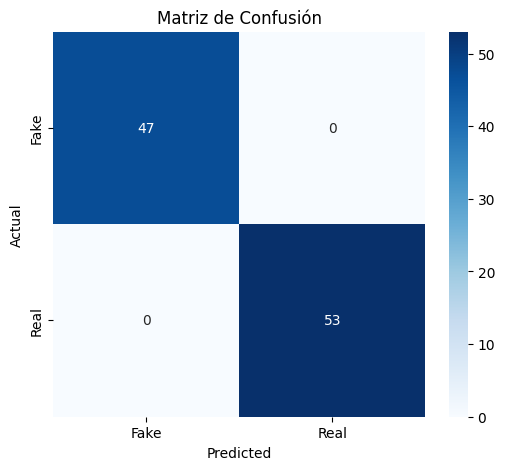

In [63]:
# Visualización
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Matriz de Confusión")
plt.show()

In [64]:
# Save the model
best_trainer.save_model("modelo_guardado/")
tokenizer.save_pretrained("modelo_guardado/")

('modelo_guardado/tokenizer_config.json',
 'modelo_guardado/special_tokens_map.json',
 'modelo_guardado/vocab.txt',
 'modelo_guardado/added_tokens.json',
 'modelo_guardado/tokenizer.json')